# Chord Recognition with Deep Learning
## Using the McGill Billboard Dataset

Dataset: https://ddmal.music.mcgill.ca/research/The_McGill_Billboard_Project_(Chord_Analysis_Dataset)/

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path
import re
from collections import Counter
import pickle
from tqdm import tqdm
import random
import json

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from datetime import datetime
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, 
    BatchNormalization, Activation, Reshape, add, multiply,
    Bidirectional, Lambda, Concatenate
)
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
    

%matplotlib inline

In [89]:
# Create project directories
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("logs", exist_ok=True)

In [90]:
# Check if GPU is detected
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

GPUs Available: []


## Constants and Configuration

In [91]:
# Constants
EPOCHS = 5  # Number of epochs for training
SAMPLE_SIZE = 150    # Number of songs to use in the sample
BATCH_SIZE = 256    # Batch size for training
RANDOM_STATE = 33
HYPERPARAMETER_TRIALS = 5
TRIAL_EPOCHS = 5

# Set random seed for reproducibility
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
    
# Path configuration
data_dir = Path('data/McGill-Billboard')
chordino_dir = data_dir / 'chordino'
lab_dir = data_dir / 'lab'
annotations_dir = data_dir / 'annotations'
index_path = data_dir / 'index.csv'

## Data Loading and Initial Exploration

In [92]:
# Load dataset index
index_df = pd.read_csv(index_path)
print(f"Total entries in index: {len(index_df)}")
print(f"Entries with complete data: {index_df['title'].notna().sum()}")

# Clean dataset
index_df = index_df.dropna(subset=['title'])
print(f'\nTotal Entries after cleaning: {len(index_df)}')

# Display dataset info
print("\nDataset Info:")
print(f"Unique songs: {index_df['title'].nunique()}")
print(f"Unique artists: {index_df['artist'].nunique()}")

Total entries in index: 1300
Entries with complete data: 890

Total Entries after cleaning: 890

Dataset Info:
Unique songs: 732
Unique artists: 420


## Temporal Analysis

In [93]:
# Temporal analysis
index_df['chart_date'] = pd.to_datetime(index_df['chart_date'])
index_df['year'] = index_df['chart_date'].dt.year
index_df['decade'] = (index_df['year'] // 10) * 10

decade_counts = index_df['decade'].value_counts().sort_index()
print("\nSongs per decade:")
print(decade_counts)


Songs per decade:
decade
1950     27
1960    252
1970    316
1980    252
1990     43
Name: count, dtype: int64


## Data Structure Verification

In [94]:
# Verify data directories
song_ids = [d.name for d in chordino_dir.iterdir() if d.is_dir()]
lab_ids = [d.name for d in lab_dir.iterdir() if d.is_dir()]
common_ids = set(song_ids).intersection(set(lab_ids))

print(f"\nChroma features available for: {len(song_ids)} songs")
print(f"Lab files available for: {len(lab_ids)} songs")
print(f"Common entries: {len(common_ids)} songs")


Chroma features available for: 890 songs
Lab files available for: 890 songs
Common entries: 890 songs


## Analyzing Chord Distribution Across the Dataset

In [95]:
def get_chord_distribution(song_ids, top_n=20):
    """Get the distribution of chords across all songs"""
    all_chords = Counter()
    processed_songs = 0
    
    # Limit to sample size if needed
    # sample_ids = song_ids[:min(SAMPLE_SIZE if SAMPLE_SIZE is not None else len(song_ids), len(song_ids))]
    sample_ids = song_ids

    for song_id in tqdm(sample_ids, desc="Analyzing chord distribution"):
        lab_path = lab_dir / song_id / "full.lab"
        
        if lab_path.exists():
            # Load and count chord labels
            lab_data = pd.read_csv(lab_path, sep='\t', header=None, names=['start_time', 'end_time', 'chord'])
            chord_counts = lab_data['chord'].value_counts().to_dict()
            
            # Add to overall counter
            all_chords.update(chord_counts)
            processed_songs += 1
    
    print(f"Processed {processed_songs} songs for chord distribution")
    return all_chords

In [96]:
# Analyze chord distribution across the sample
chord_distribution = get_chord_distribution(list(common_ids))

Analyzing chord distribution: 100%|██████████| 890/890 [00:01<00:00, 879.14it/s]

Processed 890 songs for chord distribution


In [97]:
# Get top chords
num_top_chords = 300
top_chords = chord_distribution.most_common(num_top_chords)

# Print formatted table
print(f"Most Common Chords Across the Dataset (Top {num_top_chords})")
print("-" * 36)
print(f"{'Chord':<15} {'Frequency':>15}")
print("-" * 36)
for chord, count in top_chords:
    print(f"{chord:<15} {count:>15,}")
print("-" * 36)

Most Common Chords Across the Dataset (Top 300)
------------------------------------
Chord                 Frequency
------------------------------------
G:maj                     7,639
C:maj                     7,598
A:maj                     7,326
D:maj                     7,268
E:maj                     5,784
F:maj                     5,151
N                         4,793
Bb:maj                    4,321
Ab:maj                    2,941
B:maj                     2,832
Eb:maj                    2,489
A:min                     2,039
E:min                     1,928
B:min                     1,899
D:min                     1,891
Db:maj                    1,707
G:7                       1,186
A:min7                    1,167
G:min                     1,148
D:7                       1,120
D:min7                    1,038
E:min7                    1,026
C:7                       1,023
E:7                       1,019
Gb:maj                    1,009
F:7                         987
F#:maj        

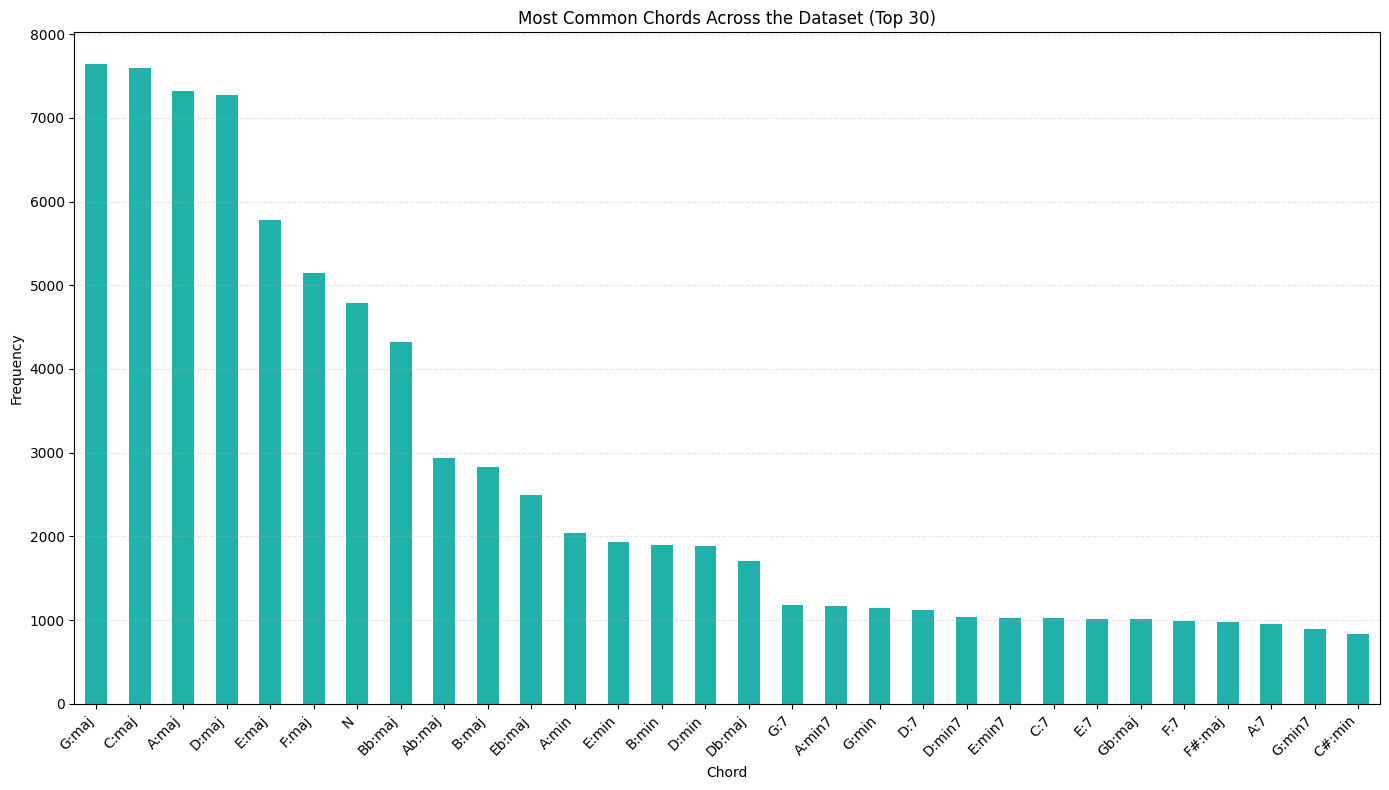

In [98]:
# Plot top chords
plt.figure(figsize=(14, 8))
top_chords = pd.Series(dict(chord_distribution.most_common(30)))
top_chords.plot(kind='bar', color='lightseagreen')
plt.title('Most Common Chords Across the Dataset (Top 30)')
plt.xlabel('Chord')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [99]:
# Print statistics
total_chords = sum(chord_distribution.values())
unique_chords = len(chord_distribution)
print(f"Total chord occurrences: {total_chords}")
print(f"Number of unique chords: {unique_chords}")

Total chord occurrences: 124895
Number of unique chords: 976


In [100]:
# How much of the dataset is covered by the top N chords?
def coverage_analysis(chord_distribution, tops=[10, 20, 50, 100, 200]):
    total = sum(chord_distribution.values())
    for n in tops:
        top_n = sum(dict(chord_distribution.most_common(n)).values())
        print(f"Top {n} chords cover {top_n/total*100:.2f}% of all chord occurrences")

In [101]:
coverage_analysis(chord_distribution)

Top 10 chords cover 44.56% of all chord occurrences
Top 20 chords cover 57.83% of all chord occurrences
Top 50 chords cover 74.94% of all chord occurrences
Top 100 chords cover 84.44% of all chord occurrences
Top 200 chords cover 92.36% of all chord occurrences


## Chord Simplification (Feature Engineering)

In [102]:
def simplify_chord(chord):
    """
    Simplify chord to one of the following types:
    - major
    - minor
    - m7b5 (half-diminished)
    - power chords (5)
    - dominant 7
    - sus2
    - sus4
    - aug (augmented)
    - dim (diminished)
    - For 1/1 chords, just output the root
    """
    if chord == 'N' or chord == 'X':
        return chord
    
    # Extract root and quality
    parts = chord.split(':')
    if len(parts) < 2:
        return chord  # Can't parse
    
    root = parts[0]
    quality = parts[1]
    
    # Handle 1/1 chords (just return the root)
    if quality == '1/1':
        return f"{root}"
    
    # Simple chord types that we keep as is
    if quality in ['maj', 'min', '7', 'sus2', 'sus4', 'aug', 'dim', '5']:
        return chord
    
    # Handle half-diminished
    if quality == 'hdim7':
        return f"{root}:m7b5"
    
    # Simplify other chord types
    if 'min' in quality:
        return f"{root}:min"
    
    if 'maj' in quality and '7' not in quality:
        return f"{root}:maj"
    
    if 'maj7' in quality or 'maj9' in quality or 'maj13' in quality:
        return f"{root}:maj"
    
    if '7' in quality or '9' in quality or '13' in quality:
        return f"{root}:7"
    
    if '5' in quality:
        return f"{root}:5"
    
    if 'sus' in quality:
        if 'sus2' in quality:
            return f"{root}:sus2"
        if 'sus4' in quality:
            return f"{root}:sus4"
    
    if 'aug' in quality:
        return f"{root}:aug"
    
    if 'dim' in quality:
        return f"{root}:dim"
    
    # Default to major if we can't determine
    return f"{root}:maj"

In [103]:
# Function to analyze the impact of simplification
def analyze_chord_simplification(chord_distribution):
    total_chords = sum(chord_distribution.values())
    original_unique = len(chord_distribution)
    
    # Create a new distribution with simplified chords
    simplified_distribution = Counter()
    mapping = {}
    
    for chord, count in chord_distribution.items():
        simplified = simplify_chord(chord)
        simplified_distribution[simplified] += count
        mapping[chord] = simplified
    
    # Count how many chords were changed
    changed_chords = sum(1 for original, simplified in mapping.items() 
                          if original != simplified)
    
    simplified_unique = len(simplified_distribution)
    
    print(f"Original number of unique chords: {original_unique}")
    print(f"Simplified number of unique chords: {simplified_unique}")
    print(f"Reduction in unique chords: {original_unique - simplified_unique} ({(original_unique - simplified_unique) / original_unique * 100:.2f}%)")
    print(f"Number of chord types that were changed: {changed_chords} ({changed_chords / original_unique * 100:.2f}%)")
    
    # Coverage analysis
    print("\nCoverage analysis after simplification:")
    total = sum(simplified_distribution.values())
    for n in [10, 20, 50]:
        top_n = sum(dict(simplified_distribution.most_common(n)).values())
        print(f"Top {n} simplified chords cover {top_n/total*100:.2f}% of all chord occurrences")
    
    # Most common simplified chords
    print("\nMost common simplified chords:")
    for chord, count in simplified_distribution.most_common(20):
        print(f"{chord:15} {count}")
    
    return simplified_distribution, mapping

In [104]:
# Run analysis
simplified_distribution, chord_mapping = analyze_chord_simplification(chord_distribution)

Original number of unique chords: 976
Simplified number of unique chords: 152
Reduction in unique chords: 824 (84.43%)
Number of chord types that were changed: 858 (87.91%)

Coverage analysis after simplification:
Top 10 simplified chords cover 54.18% of all chord occurrences
Top 20 simplified chords cover 75.42% of all chord occurrences
Top 50 simplified chords cover 95.98% of all chord occurrences

Most common simplified chords:
C:maj           9339
D:maj           9133
G:maj           9116
A:maj           8765
F:maj           6885
E:maj           6649
Bb:maj          5277
N               4793
A:min           3995
Ab:maj          3721
D:min           3634
E:min           3490
B:maj           3183
Eb:maj          3099
B:min           3016
Db:maj          2417
G:min           2239
E:7             1978
G:7             1756
C:min           1717


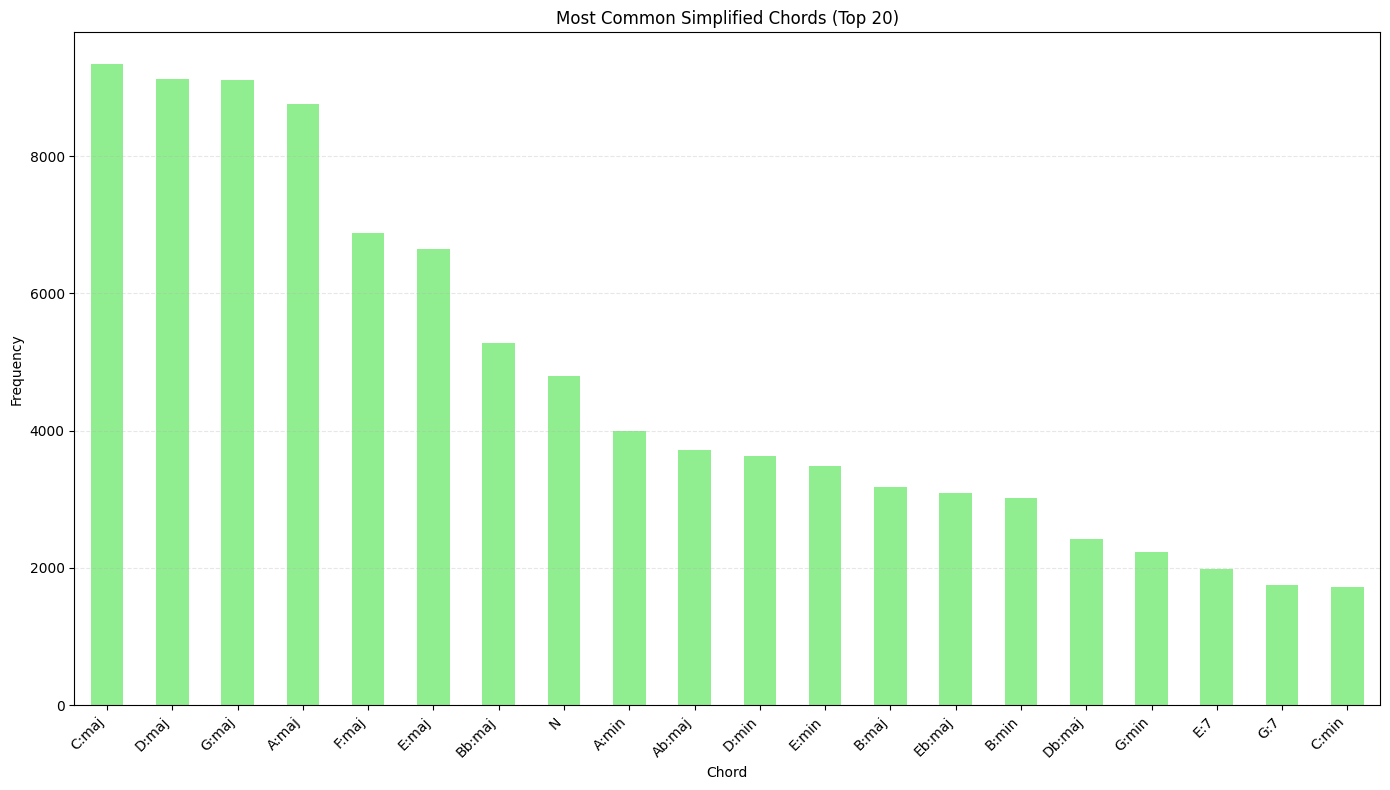

In [105]:
# Visualize the simplified chord distribution
plt.figure(figsize=(14, 8))
top_simplified_chords = pd.Series(dict(simplified_distribution.most_common(20)))
top_simplified_chords.plot(kind='bar', color='lightgreen')
plt.title('Most Common Simplified Chords (Top 20)')
plt.xlabel('Chord')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [106]:
# Let's see which original chords were mapped to each simplified chord
def show_mapping_details(simplified_chord, chord_mapping, chord_distribution, top_n=10):
    original_chords = [(orig, chord_distribution[orig]) for orig, simp in chord_mapping.items() 
                      if simp == simplified_chord]
    sorted_originals = sorted(original_chords, key=lambda x: x[1], reverse=True)
    
    print(f"\nOriginal chords that were simplified to {simplified_chord}:")
    for orig, count in sorted_originals[:top_n]:
        print(f"{orig:20} {count}")
    if len(sorted_originals) > top_n:
        print(f"...and {len(sorted_originals) - top_n} more")

# Display mapping details for a few important simplified chords
for chord in simplified_distribution.most_common(5):
    show_mapping_details(chord[0], chord_mapping, chord_distribution)


Original chords that were simplified to C:maj:
C:maj                7598
C:maj7               360
C:maj/5              273
C:maj(9)             266
C:maj/3              189
C:maj/4              133
C:maj/2              132
C:maj9               117
C:maj6               70
C:maj9/3             38
...and 13 more

Original chords that were simplified to D:maj:
D:maj                7268
D:maj/5              636
D:maj7               299
D:maj/3              248
D:maj/2              147
D:maj6               142
D:maj(9)             102
D:maj/4              55
D:maj9               41
D:maj7/2             39
...and 16 more

Original chords that were simplified to G:maj:
G:maj                7639
G:maj7               317
G:maj(9)             303
G:maj/5              218
G:maj/3              162
G:maj/2              117
G:maj9               75
G:maj6               66
G:11                 42
G:maj/4              35
...and 15 more

Original chords that were simplified to A:maj:
A:maj              

## Sampling

In [107]:
# Take a sample of the common_ids based on SAMPLE_SIZE
sampled_ids = random.sample(list(common_ids), min(SAMPLE_SIZE, len(common_ids)))
print(f"\nUsing {len(sampled_ids)} songs for analysis (SAMPLE_SIZE={SAMPLE_SIZE})")


Using 150 songs for analysis (SAMPLE_SIZE=150)


## Example Song Analysis

In [108]:
# Random example analysis - select from our sampled IDs for consistency
example_id = random.choice(sampled_ids)

# Load chroma features
chroma_path = chordino_dir / example_id / 'bothchroma.csv'
chroma_data = pd.read_csv(chroma_path, header=None)
print(f"\nChroma data shape for {example_id}: {chroma_data.shape}")

# Load chord labels
lab_data = pd.read_csv(lab_dir / example_id / "full.lab", sep='\t', names=['start', 'end', 'chord'])

# Apply chord simplification to the loaded data
lab_data['original_chord'] = lab_data['chord']
lab_data['chord'] = lab_data['chord'].apply(simplify_chord)

print(f"\nChord segments count: {len(lab_data)}")
print("\nMost common simplified chords:")
print(lab_data['chord'].value_counts().head(10))


Chroma data shape for 1024: (3666, 26)

Chord segments count: 79

Most common simplified chords:
chord
E:7    41
B:7    23
A:7    10
N       5
Name: count, dtype: int64


In [109]:
# Compare with original chords
print("\nComparison with original chords:")
comparison_df = pd.DataFrame({
    'Original': lab_data['original_chord'].value_counts().head(60),
    'Simplified': lab_data['chord'].value_counts().head(60)
})
print(comparison_df)


Comparison with original chords:
       Original  Simplified
A:7          10        10.0
B:7          15        23.0
B:7/5         8         NaN
E:7          41        41.0
N             5         5.0


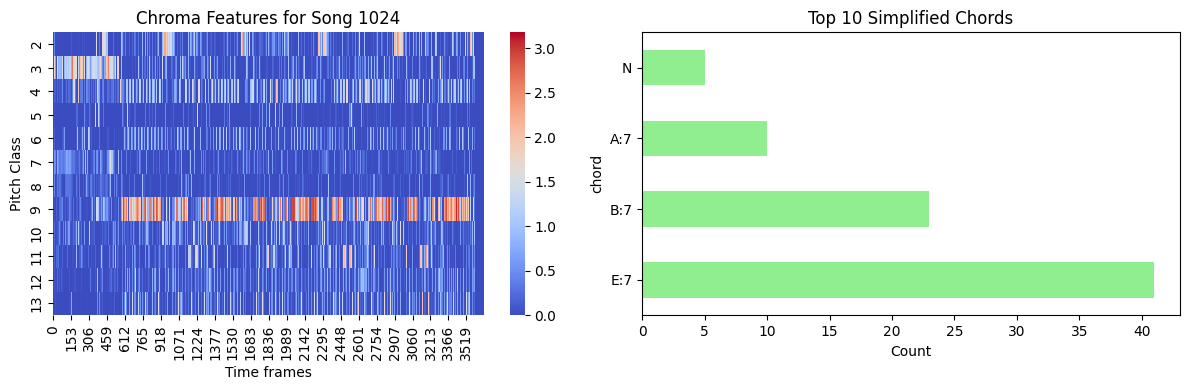

In [110]:
# Visualization
plt.figure(figsize=(12, 4))

# Plot the chroma features
plt.subplot(1, 2, 1)
sns.heatmap(chroma_data.iloc[:, 2:14].T, cmap='coolwarm', cbar=True)
plt.title(f'Chroma Features for Song {example_id}')
plt.xlabel('Time frames')
plt.ylabel('Pitch Class')

# Plot chord distribution
plt.subplot(1, 2, 2)
lab_data['chord'].value_counts().head(10).plot(kind='barh', color='lightgreen')
plt.title('Top 10 Simplified Chords')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

## Data Processing Pipeline

In [111]:
def load_and_align_song_data(song_id, chordino_dir, lab_dir, simplify_chord_fn):
    """
    Load and align chroma features with chord labels for a single song
    
    Args:
        song_id: ID of the song
        chordino_dir: Directory containing chroma features
        lab_dir: Directory containing chord labels
        simplify_chord_fn: Function to simplify chord labels
    
    Returns:
        tuple: (chroma_features, aligned_chord_labels)
    """
    # Load chroma features
    chroma_path = chordino_dir / song_id / 'bothchroma.csv'
    chroma_data = pd.read_csv(chroma_path, header=None)
    chroma_array = chroma_data.iloc[:, 2:14].values.astype(np.float32)
    chroma_array = np.nan_to_num(chroma_array)  # Handle NaN values
    
    # Load chord labels
    lab_path = lab_dir / song_id / "full.lab"
    chord_data = pd.read_csv(lab_path, sep='\t', names=['start_time', 'end_time', 'chord'])
    
    # Apply chord simplification
    chord_data['chord'] = chord_data['chord'].apply(simplify_chord_fn)
    
    # Align chroma features with chord labels
    hop_size = 0.01  # 10ms hop size (typical for Chordino)
    chroma_times = np.arange(len(chroma_array)) * hop_size
    
    aligned_chords = []
    for t in chroma_times:
        matching = chord_data[(chord_data['start_time'] <= t) & (chord_data['end_time'] > t)]
        if not matching.empty:
            aligned_chords.append(matching['chord'].values[0])
        else:
            aligned_chords.append('N')  # No chord label
    
    return chroma_array, np.array(aligned_chords)

def create_windowed_examples(features, labels, window_size=15, hop_size=1):
    """
    Create windowed examples from a sequence of features and labels
    
    Args:
        features: Chroma features array (frames × features)
        labels: Chord labels array
        window_size: Number of frames in each window
        hop_size: Number of frames to hop between windows
    
    Returns:
        tuple: (windowed_features, window_labels)
    """
    num_frames = len(features)
    X_windows, y_labels = [], []
    
    for i in range(0, num_frames - window_size + 1, hop_size):
        # Extract window of chroma features
        window = features[i:i + window_size]
        
        # Use the chord label from the center of the window
        center_idx = i + window_size // 2
        label = labels[center_idx]
        
        X_windows.append(window)
        y_labels.append(label)
    
    return np.array(X_windows), np.array(y_labels)

def prepare_dataset(song_ids, chordino_dir, lab_dir, simplify_chord_fn, 
                   window_size=15, hop_size=1, test_size=0.2, val_size=0.1,
                   random_state=42, max_songs=None):
    """
    Prepare complete dataset with windows, including train/val/test splits
    
    Args:
        song_ids: List of song IDs
        chordino_dir: Directory containing chroma features
        lab_dir: Directory containing chord labels
        simplify_chord_fn: Function to simplify chord labels
        window_size: Number of frames in each window
        hop_size: Number of frames to hop between windows
        test_size: Proportion of data for testing
        val_size: Proportion of training data for validation
        random_state: Random seed for reproducibility
        max_songs: Maximum number of songs to process (for debugging)
    
    Returns:
        dict: Dataset splits and metadata
    """
    # Limit number of songs if needed
    if max_songs is not None:
        song_ids = song_ids[:min(max_songs, len(song_ids))]
    
    print(f"Preparing dataset from {len(song_ids)} songs...")
    
    all_features = []
    all_labels = []
    processed_songs = 0
    
    # Process each song
    for song_id in tqdm(song_ids, desc="Processing songs"):
        try:
            # Load and align features and labels
            features, labels = load_and_align_song_data(
                song_id, chordino_dir, lab_dir, simplify_chord_fn
            )
            
            # Create windowed examples
            X_windows, y_windows = create_windowed_examples(
                features, labels, window_size, hop_size
            )
            
            all_features.append(X_windows)
            all_labels.append(y_windows)
            processed_songs += 1
            
        except Exception as e:
            print(f"Error processing song {song_id}: {str(e)}")
    
    print(f"Successfully processed {processed_songs} songs")
    
    # Combine data from all songs
    X = np.vstack(all_features)
    y = np.concatenate(all_labels)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_onehot = to_categorical(y_encoded)
    
    print(f"Total examples: {len(X)}")
    print(f"Number of chord classes: {len(label_encoder.classes_)}")
    
    # Split into train+val and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y_onehot, test_size=test_size, random_state=random_state, stratify=np.argmax(y_onehot, axis=1)
    )
    
    # Further split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(1-test_size), 
        random_state=random_state, stratify=np.argmax(y_train_val, axis=1)
    )
    
    # Return dataset splits and metadata
    return {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
        'label_encoder': label_encoder,
        'window_size': window_size,
        'hop_size': hop_size,
        'num_features': X.shape[2],
        'num_classes': y_onehot.shape[1]
    }

## Dataset Preparation

In [112]:
dataset = prepare_dataset(
    song_ids=sampled_ids,
    chordino_dir=chordino_dir,
    lab_dir=lab_dir,
    simplify_chord_fn=simplify_chord,
    window_size=15,
    hop_size=5
    )

Preparing dataset from 150 songs...


Processing songs: 100%|██████████| 150/150 [02:39<00:00,  1.06s/it]


Successfully processed 150 songs
Total examples: 137888
Number of chord classes: 96


## Model Architecture

In [125]:
def build_optimized_chord_model(
    input_shape,
    num_classes,
    window_size,
    conv_filters=[64, 128],
    conv_kernel_size=3,
    pool_size=2,
    use_bottleneck=True,
    bottleneck_size=32,
    use_residual=True,
    use_attention=True,
    lstm_units=[128, 64],
    dense_units=[64],
    dropout_rate=0.3,
    learning_rate=0.001
):
    """
    Build an optimized hybrid model for chord recognition with configurable hyperparameters
    
    Args:
        input_shape: Number of features (12 for chroma)
        num_classes: Number of chord classes
        window_size: Number of frames in each window
        conv_filters: List of filter sizes for Conv1D layers
        conv_kernel_size: Kernel size for Conv1D layers
        pool_size: Pool size for MaxPooling1D layers
        use_bottleneck: Whether to use bottleneck layers
        bottleneck_size: Size of bottleneck layer
        use_residual: Whether to use residual connections
        use_attention: Whether to use attention mechanism
        lstm_units: List of unit sizes for LSTM layers
        dense_units: List of unit sizes for Dense layers
        dropout_rate: Dropout rate
        learning_rate: Learning rate for Adam optimizer
    
    Returns:
        Compiled model
    """
    # Check if window_size is too small for the number of pooling layers
    min_sequence_length = window_size
    for _ in range(len(conv_filters)):
        min_sequence_length = min_sequence_length // pool_size
        if min_sequence_length < 1:
            # Adjust the model to use fewer pooling layers
            conv_filters = conv_filters[:1]  # Use only first conv layer
            print(f"Warning: Window size {window_size} is too small for multiple pooling layers. Reducing to {len(conv_filters)} conv layers.")
            
    # Input layer
    inputs = Input(shape=(window_size, input_shape))
    
    # CNN feature extraction
    x = inputs
    skip_connection = None
    
    # Apply convolutional layers
    for i, filters in enumerate(conv_filters):
        x = Conv1D(
            filters=filters,
            kernel_size=conv_kernel_size,
            activation='relu',
            padding='same',
            name=f'conv1d_{i+1}'
        )(x)
        x = BatchNormalization(name=f'bn_conv_{i+1}')(x)
        
        # Save tensor for residual connection
        if i == 0 and use_residual:
            skip_connection = x
            
        # Apply pooling with safety check
        if i < len(conv_filters) - 1:  # No pooling after last conv layer
            # Get current temporal dimension size
            current_length = x.shape[1]
            
            # Only apply pooling if we have enough temporal dimension left
            if current_length >= pool_size:
                x = MaxPooling1D(pool_size=pool_size, name=f'pool_{i+1}')(x)
            else:
                print(f"Skipping pooling at layer {i+1} because sequence length {current_length} < pool_size {pool_size}")
    
    # Apply bottleneck if specified
    if use_bottleneck:
        x = Conv1D(
            filters=bottleneck_size,
            kernel_size=1,
            activation='relu',
            padding='same',
            name='bottleneck'
        )(x)
        x = BatchNormalization(name='bn_bottleneck')(x)
    
    # Add residual connection if specified
    if use_residual and skip_connection is not None:
        # Skip residual connection if temporal dimension is zero
        if x.shape[1] <= 0 or skip_connection.shape[1] <= 0:
            print("Skipping residual connection due to invalid dimensions")
        else:
            # Ensure compatible shapes
            if skip_connection.shape[1:] != x.shape[1:]:
                skip_connection = Conv1D(
                    filters=x.shape[-1],
                    kernel_size=1,
                    padding='same',
                    name='skip_adjust'
                )(skip_connection)
                
                # If shapes still don't match in time dimension and both dimensions are valid
                if skip_connection.shape[1] != x.shape[1] and skip_connection.shape[1] > 0 and x.shape[1] > 0:
                    # Safely calculate pool factor
                    if x.shape[1] == 0:
                        # Skip residual if target dimension is 0
                        print("Cannot create residual connection - target dimension is 0")
                    else:
                        pool_factor = int(skip_connection.shape[1] / x.shape[1])
                        if pool_factor > 1:
                            skip_connection = MaxPooling1D(
                                pool_size=pool_factor,
                                name='skip_pool'
                            )(skip_connection)
            
            # Only add the residual connection if dimensions match now
            if skip_connection.shape[1:] == x.shape[1:]:
                x = add([x, skip_connection], name='residual_connection')
            else:
                print(f"Skipping residual connection. Shapes don't match: {skip_connection.shape} vs {x.shape}")
    
    # Recurrent layers
    for i, units in enumerate(lstm_units):
        return_sequences = i < len(lstm_units) - 1
        
        # Use bidirectional LSTMs
        x = Bidirectional(
            LSTM(units, return_sequences=return_sequences),
            name=f'bilstm_{i+1}'
        )(x)
        
        # Only apply dropout to intermediate layers
        if i < len(lstm_units) - 1:
            x = Dropout(dropout_rate, name=f'lstm_dropout_{i+1}')(x)
    
    # Apply attention mechanism if specified
    if use_attention and len(lstm_units) > 0:
        # If last LSTM doesn't return sequences, we need another LSTM for attention
        if not return_sequences:
            x = Reshape((1, x.shape[-1]))(x)
            return_sequences = True
        
        # Self-attention mechanism
        attention = Dense(1, activation='tanh', name='attention_dense')(x)
        attention = Reshape((attention.shape[1],), name='attention_reshape')(attention)
        attention = Activation('softmax', name='attention_weights')(attention)
        attention = Reshape((attention.shape[1], 1), name='attention_reshape2')(attention)
        
        # Apply attention weights
        x = multiply([x, attention], name='apply_attention')
        x = Lambda(lambda x: K.sum(x, axis=1), name='context_vector')(x)
    
    # Dense classification layers
    for i, units in enumerate(dense_units):
        x = Dense(units, activation='relu', name=f'dense_{i+1}')(x)
        x = BatchNormalization(name=f'bn_dense_{i+1}')(x)
        x = Dropout(dropout_rate, name=f'dense_dropout_{i+1}')(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    
    return model

def create_model_callbacks(
    checkpoint_path='best_chord_model.keras',
    patience_early=15,
    patience_lr=7,
    min_delta=0.001,
    factor=0.5,
    min_lr=0.00001,
    monitor='val_loss'
):
    """
    Create callbacks for model training
    
    Args:
        checkpoint_path: Path to save best model
        patience_early: Patience for early stopping
        patience_lr: Patience for learning rate reduction
        min_delta: Minimum change to count as improvement
        factor: Factor by which to reduce learning rate
        min_lr: Minimum learning rate
        monitor: Metric to monitor
    
    Returns:
        List of callbacks
    """
    
    # Create logs directory
    log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
    os.makedirs(log_dir, exist_ok=True)
    
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor=monitor,
            min_delta=min_delta,
            patience=patience_early,
            verbose=1,
            restore_best_weights=True
        ),
        
        # Save best model
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor=monitor,
            save_best_only=True,
            verbose=1
        ),
        
        # Reduce learning rate when plateau
        ReduceLROnPlateau(
            monitor=monitor,
            factor=factor,
            patience=patience_lr,
            verbose=1,
            min_lr=min_lr
        ),
        
        # TensorBoard logging
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
    
    return callbacks

In [126]:
model = build_optimized_chord_model(
    input_shape=dataset['num_features'],
    num_classes=dataset['num_classes'],
    window_size=dataset['window_size']
)
callbacks = create_model_callbacks()

In [127]:
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 15, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 15, 64)    │      2,368 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv_1           │ (None, 15, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_1              │ (None, 7, 64)     │          0 │ bn_conv_1[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 7, 128)    │     24,704 │ pool_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv_2           │ (None, 7, 128)    │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck (Conv1D) │ (None, 7, 32)     │      4,128 │ bn_conv_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_adjust         │ (None, 15, 32)    │      2,080 │ bn_conv_1[0][0]   │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_bottleneck       │ (None, 7, 32)     │        128 │ bottleneck[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_pool           │ (None, 7, 32)     │          0 │ skip_adjust[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_connection │ (None, 7, 32)     │          0 │ bn_bottleneck[0]… │
│ (Add)               │                   │            │ skip_pool[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_1            │ (None, 7, 256)    │    164,864 │ residual_connect… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dropout_1      │ (None, 7, 256)    │          0 │ bilstm_1[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_2            │ (None, 128)       │    164,352 │ lstm_dropout_1[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1, 128)    │          0 │ bilstm_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dense     │ (None, 1, 1)      │        129 │ reshape_9[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_reshape   │ (None, 1)         │          0 │ attention_dense[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 1)         │          0 │ attention_reshap… │
│ (Activation)        │                   │            │                 

 Total params: 378,273 (1.44 MB)

 Trainable params: 377,697 (1.44 MB)

 Non-trainable params: 576 (2.25 KB)

## Model Training

In [128]:
# Hyperparameter tuning
def hyperparameter_tuning(dataset, n_trials=5, epochs=15):
    """
    Perform hyperparameter tuning for the chord recognition model.
    
    Args:
        dataset: Dictionary containing dataset splits and metadata
        n_trials: Number of hyperparameter combinations to try
        epochs: Number of epochs to train each model
        
    Returns:
        dict: Best hyperparameters found
    """
    
    # Define hyperparameter search space
    hyperparameter_space = {
        'conv_filters': [
            [32, 64],
            [64, 128], 
            [64, 128, 256],
            [32, 64, 128, 256]
        ],
        'conv_kernel_size': [3, 5, 7],
        'pool_size': [2, 3],
        'use_bottleneck': [True, False],
        'bottleneck_size': [16, 32, 64],
        'use_residual': [True, False],
        'use_attention': [True, False],
        'lstm_units': [
            [64],
            [128, 64],
            [256, 128]
        ],
        'dense_units': [
            [64],
            [128, 64],
            [256, 128, 64]
        ],
        'dropout_rate': [0.2, 0.3, 0.4, 0.5],
        'learning_rate': [0.01, 0.001, 0.0005, 0.0001]
    }
    
    # Track best performance and parameters
    best_val_acc = 0
    best_params = None
    trials_results = []
    
    print(f"Starting hyperparameter tuning with {n_trials} trials...")
    for trial in range(n_trials):
        # Sample hyperparameters
        params = {
            'conv_filters': random.choice(hyperparameter_space['conv_filters']),
            'conv_kernel_size': random.choice(hyperparameter_space['conv_kernel_size']),
            'pool_size': random.choice(hyperparameter_space['pool_size']),
            'use_bottleneck': random.choice(hyperparameter_space['use_bottleneck']),
            'bottleneck_size': random.choice(hyperparameter_space['bottleneck_size']),
            'use_residual': random.choice(hyperparameter_space['use_residual']),
            'use_attention': random.choice(hyperparameter_space['use_attention']),
            'lstm_units': random.choice(hyperparameter_space['lstm_units']),
            'dense_units': random.choice(hyperparameter_space['dense_units']),
            'dropout_rate': random.choice(hyperparameter_space['dropout_rate']),
            'learning_rate': random.choice(hyperparameter_space['learning_rate'])
        }
        
        print(f"\nTrial {trial+1}/{n_trials}")
        print("Parameters:", params)
        
        # Build model with these hyperparameters
        model = build_optimized_chord_model(
            input_shape=dataset['num_features'],
            num_classes=dataset['num_classes'],
            window_size=dataset['window_size'],
            **params
        )
        
        # Simple callbacks for tuning (early stopping only)
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
        ]
        
        # Train model
        history = model.fit(
            dataset['X_train'], 
            dataset['y_train'],
            epochs=epochs,
            batch_size=256,
            validation_data=(dataset['X_val'], dataset['y_val']),
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate model
        val_loss, val_acc = model.evaluate(dataset['X_val'], dataset['y_val'], verbose=0)
        
        # Record results
        trial_result = {
            'trial': trial + 1,
            'params': params,
            'val_acc': val_acc,
            'val_loss': val_loss,
            'history': history.history
        }
        trials_results.append(trial_result)
        
        print(f"Validation accuracy: {val_acc:.4f}")
        
        # Check if this is the best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            print(f"New best validation accuracy: {best_val_acc:.4f}")
    
    print("\nHyperparameter Tuning Results")
    print("="*50)
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print("Best hyperparameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    # Visualize trials results
    plt.figure(figsize=(12, 6))
    
    # Sort trials by accuracy
    sorted_trials = sorted(trials_results, key=lambda x: x['val_acc'])
    
    trial_indices = [t['trial'] for t in sorted_trials]
    accuracies = [t['val_acc'] for t in sorted_trials]
    
    plt.bar(range(len(trial_indices)), accuracies, color='skyblue')
    plt.xlabel('Trial (sorted by accuracy)')
    plt.ylabel('Validation Accuracy')
    plt.title('Hyperparameter Tuning Results')
    plt.xticks(range(len(trial_indices)), trial_indices)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_params, trials_results

In [ ]:
# Run hyperparameter tuning with a small number of trials for demonstration
best_params, trials_results = hyperparameter_tuning(dataset, n_trials=HYPERPARAMETER_TRIALS, epochs=TRIAL_EPOCHS)

Starting hyperparameter tuning with 5 trials...

Trial 1/5
Parameters: {'conv_filters': [64, 128, 256], 'conv_kernel_size': 5, 'pool_size': 2, 'use_bottleneck': False, 'bottleneck_size': 64, 'use_residual': False, 'use_attention': False, 'lstm_units': [128, 64], 'dense_units': [64], 'dropout_rate': 0.2, 'learning_rate': 0.01}
Epoch 1/5
378/378 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.1409 - loss: 3.4787 - val_accuracy: 0.1812 - val_loss: 3.1288
Epoch 2/5
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.1777 - loss: 3.1122 - val_accuracy: 0.1825 - val_loss: 3.0772
Epoch 3/5
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.1856 - loss: 3.0482 - val_accuracy: 0.1845 - val_loss: 3.0494
Epoch 4/5
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.1953 - loss: 2.9942 - val_accuracy: 0.1994 - val_loss: 2.9731
Epoch 5/5
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.2023 - loss: 2.9516 - val_accuracy: 0.2059 - val_loss: 2.9343
Validation accuracy: 0.2059

In [ ]:
# Build model with best hyperparameters
best_model = build_optimized_chord_model(
    input_shape=dataset['num_features'],
    num_classes=dataset['num_classes'],
    window_size=dataset['window_size'],
    **best_params
)

# Create callbacks for the full training
best_callbacks = create_model_callbacks(
    checkpoint_path='models/best_chord_model.keras',
    patience_early=15,
    patience_lr=7)

In [ ]:
def train_final_model(dataset, model, callbacks, epochs=EPOCHS, batch_size=256, verbose=1):
    """
    Train the final model on the full dataset.
    
    Args:
        dataset: Dictionary containing dataset splits and metadata
        model: Model to train
        callbacks: Callbacks for training
        epochs: Number of epochs to train
        batch_size: Batch size for training
        verbose: Verbosity level
        
    Returns:
        History object
    """
    print("Training final model...")
    
    # Train model with best hyperparameters
    history = model.fit(
        dataset['X_train'],
        dataset['y_train'],
        validation_data=(dataset['X_val'], dataset['y_val']),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose
    )
    
    return history

# Train the final model
history = train_final_model(dataset, best_model, best_callbacks, epochs=EPOCHS, batch_size=BATCH_SIZE)

Training final model...
Epoch 1/5


c:\Users\RohanGupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0829 - loss: 4.4027
Epoch 1: val_loss improved from inf to 3.36976, saving model to models/best_chord_model.keras
378/378 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.0830 - loss: 4.4017 - val_accuracy: 0.1866 - val_loss: 3.3698 - learning_rate: 5.0000e-04
Epoch 2/5
377/378 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1566 - loss: 3.4646
Epoch 2: val_loss improved from 3.36976 to 3.05954, saving model to models/best_chord_model.keras
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.1566 - loss: 3.4642 - val_accuracy: 0.2025 - val_loss: 3.0595 - learning_rate: 5.0000e-04
Epoch 3/5
376/378 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1786 - loss: 3.1834
Epoch 3: val_loss improved from 3.05954 to 2.95420, saving model to models/best_chord_model.keras
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.1787 - loss: 3.1831 - val_accuracy: 0.2143 - val_loss: 2.9542 - learning_rate: 5.0000e-04
Epoch 4/5
377/378 ━━━━━

## Model Evaluation

C:\Users\RohanGupta\AppData\Local\Temp\ipykernel_13232\130424417.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_acc, val_acc], labels=['Train', 'Validation'])


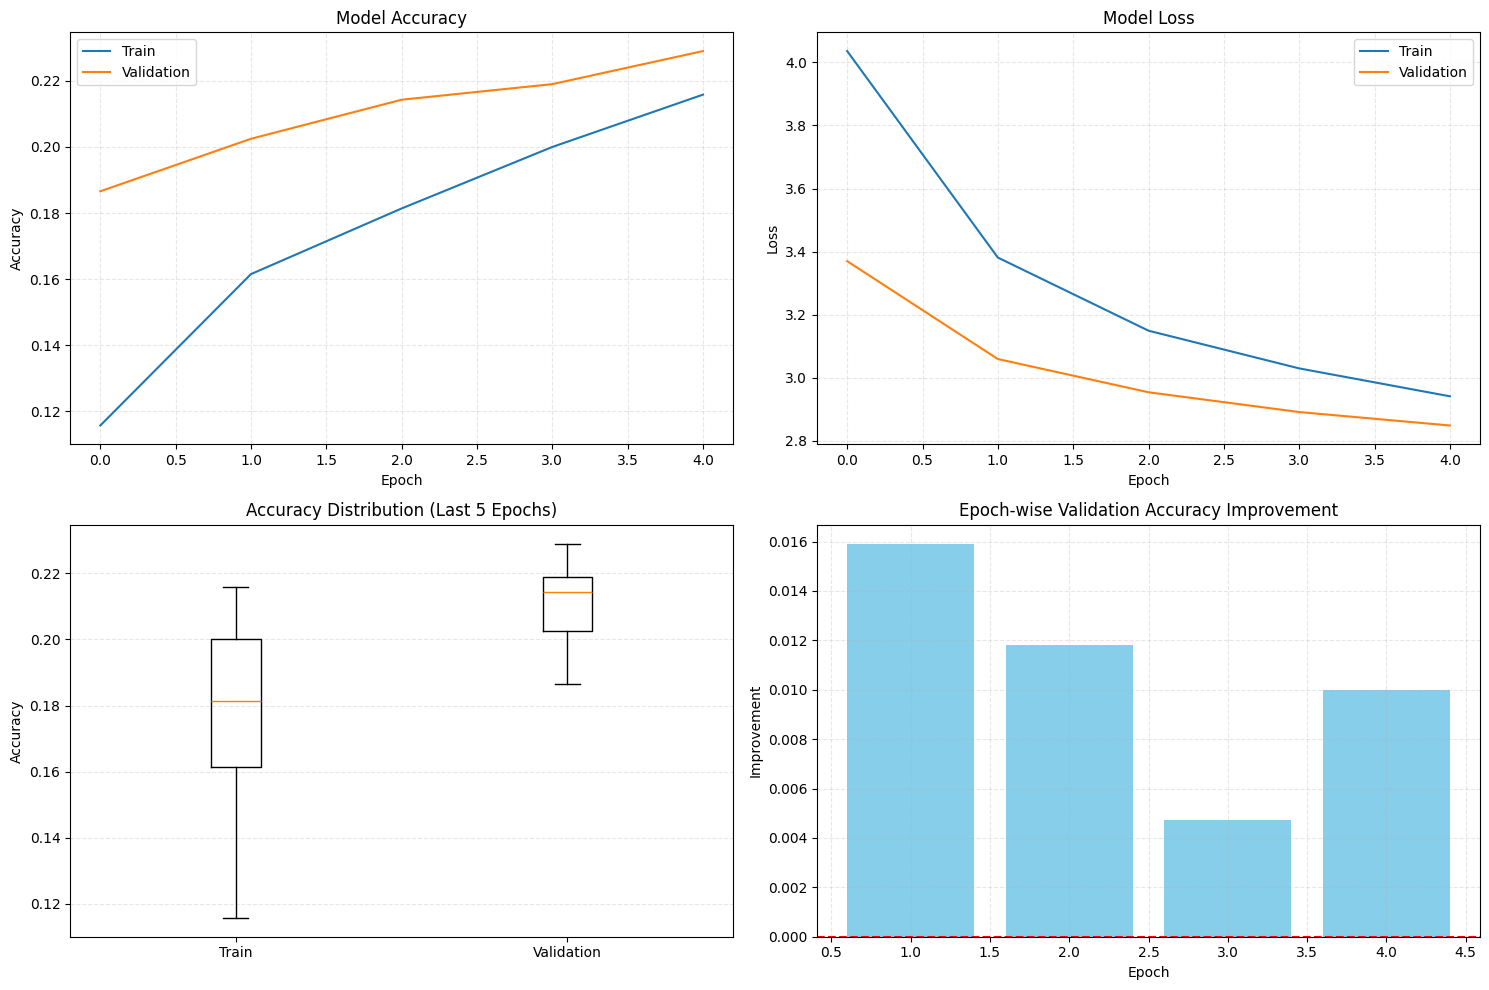

In [ ]:
# Plot training history
def plot_training_history(history):
    """
    Plot training history with detailed metrics.
    
    Args:
        history: History object from model training
    """
    plt.figure(figsize=(15, 10))
    
    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.3)
    
    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.3)
    
    # Plot accuracy distribution (last 10 epochs)
    plt.subplot(2, 2, 3)
    last_epochs = min(10, len(history.history['accuracy']))
    
    train_acc = history.history['accuracy'][-last_epochs:]
    val_acc = history.history['val_accuracy'][-last_epochs:]
    
    plt.boxplot([train_acc, val_acc], labels=['Train', 'Validation'])
    plt.title(f'Accuracy Distribution (Last {last_epochs} Epochs)')
    plt.ylabel('Accuracy')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Plot learning rate if available
    if 'lr' in history.history:
        plt.subplot(2, 2, 4)
        plt.semilogy(history.history['lr'])
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate (log scale)')
        plt.grid(linestyle='--', alpha=0.3)
    else:
        # Plot epoch-wise improvement if learning rate not available
        plt.subplot(2, 2, 4)
        val_acc = history.history['val_accuracy']
        improvements = [val_acc[i] - val_acc[i-1] for i in range(1, len(val_acc))]
        plt.bar(range(1, len(val_acc)), improvements, color='skyblue')
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title('Epoch-wise Validation Accuracy Improvement')
        plt.xlabel('Epoch')
        plt.ylabel('Improvement')
        plt.grid(linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot the training history
plot_training_history(history)

In [ ]:
# Save model and training history
def save_training_artifacts(model, history, dataset, best_params, filepath_prefix='results/chord_recognition'):
    """
    Save model, history, and metadata.
    
    Args:
        model: Trained model
        history: Training history
        dataset: Dataset information
        best_params: Best hyperparameters
        filepath_prefix: Prefix for saved files
    """
    
    # Create timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save model
    model_path = f"{filepath_prefix}_model_{timestamp}.keras"
    model.save(model_path)
    print(f"Model saved to {model_path}")
    
    # Save history
    history_path = f"{filepath_prefix}_history_{timestamp}.pkl"
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"Training history saved to {history_path}")
    
    # Save label encoder
    encoder_path = f"{filepath_prefix}_encoder_{timestamp}.pkl"
    with open(encoder_path, 'wb') as f:
        pickle.dump(dataset['label_encoder'], f)
    print(f"Label encoder saved to {encoder_path}")
    
    # Save hyperparameters and metadata
    metadata = {
        'timestamp': timestamp,
        'window_size': dataset['window_size'],
        'hop_size': dataset['hop_size'],
        'num_features': dataset['num_features'],
        'num_classes': dataset['num_classes'],
        'hyperparameters': best_params,
        'final_val_accuracy': history.history['val_accuracy'][-1],
        'final_val_loss': history.history['val_loss'][-1]
    }
    
    metadata_path = f"{filepath_prefix}_metadata_{timestamp}.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"Metadata saved to {metadata_path}")
    
    return {
        'model_path': model_path,
        'history_path': history_path,
        'encoder_path': encoder_path,
        'metadata_path': metadata_path
    }

# Save all training artifacts
saved_paths = save_training_artifacts(best_model, history, dataset, best_params)

Model saved to results/chord_recognition_model_20250312_141401.keras
Training history saved to results/chord_recognition_history_20250312_141401.pkl
Label encoder saved to results/chord_recognition_encoder_20250312_141401.pkl
Metadata saved to results/chord_recognition_metadata_20250312_141401.json
